# TK Module 2

## Setup

In [221]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt

In [222]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Bars

Time-Bars, downsampled to every x interval of time. 

Ticks, price at transaction. If there's only one transation in the whole day, there is only row for that whole day. If there's thousands, you get thousands of records.

Volume bar is sampled at a certain volume threshold. So if 10 shares are traded and the treshold is 10, then a record is produced. If 9 ticks occur for 1 share each, no record is produced. 

Dollar bar is very similar to volume but instead of being measured in number of shares traded, it's measured in amount of dollars traded. 


In [223]:
def normal_returns(dataframe, column = 'price'):
    """
    gives returns without any transformations

    Parameters
    ----------
    dataframe: give the dataframe you want to use
    
    column: give the name of the column 
    that holds the pricing data you want to use
    """
    simple_returns = dataframe[column].pct_change().dropna()
    return simple_returns

def log_returns(dataframe, column = 'price'):
    """
    gives returns without a log transform

    Parameters
    ----------
    dataframe: give the dataframe you want to use
    
    column: give the name of the column 
    that holds the pricing data you want to use
    """
    log_returns = np.log(dataframe[column] / dataframe[column].shift(1)).dropna()
    return log_returns

In [224]:
class BarType:
    def __init__(self, name, colchoice = 'close'):
        self.name = name
        self.colchoice = colchoice
        

    def readCSV(self, filename):
        self.dataframe = pd.read_csv(DATAPATH + filename, index_col=0, parse_dates=True)
        self.dataframe = self.dataframe.sort_values(by='date_time', ascending=True)
        self.norm_returns = normal_returns(self.dataframe, self.colchoice)
        self.log_returns = log_returns(self.dataframe, self.colchoice)

    def useDataframe(self, dataframe):
        self.dataframe = dataframe.copy()
        self.dataframe = self.dataframe.sort_values(by='date_time', ascending=True)
        self.norm_returns = normal_returns(self.dataframe, self.colchoice)
        self.log_returns = log_returns(self.dataframe, self.colchoice)

    def giveQQ(self, choice='log', plotter = plt):
        if choice == 'log':
            stats.probplot(self.log_returns, dist='norm', plot=plotter)
        elif choice == 'normal':
            stats.probplot(self.norm_returns, dist='norm', plot=plotter)
        else:
            print('error, choose log or normal')
            



In [225]:
DATAPATH = 'C:/Users/tkkim/Desktop/nw_msds/451_financial_machine_learning/week_2/'

In [226]:
aapl_1min = BarType('AAPL_1min_time_bars', 'price')
aapl_1min.readCSV('AAPL_1min.csv')

In [227]:
aapl_1min = BarType('AAPL_1min_time_bars', 'price')
aapl_1min.readCSV('AAPL_1min.csv')

In [228]:
aapl_dollar = BarType('AAPL_dollar_bars', 'close')
aapl_dollar.readCSV('AAPL_dollar_bars_3300000.csv')

In [229]:
aapl_tick = BarType('AAPL_tick_bars', 'close')
aapl_tick.readCSV('AAPL_tick_bars_100.csv')

In [230]:
aapl_volume = BarType('AAPL_volume_bars', 'close')
aapl_volume.readCSV('AAPL_volume_bars_22000.csv')

## Question 1 

**How does bar data differ from tick data? (5 points)**

Bar data aggregates raw tick data. Time bars aggregate based on intervals of time, Volume bars aggregate on the number of shares traded, and Dollar bars aggregate on the dollar amount traded.

Tick data is every transaction for any amount of shares or dollars at any time.

## Question 2

**What does “dollar bar” mean? Does it mean that the prices have moved a certain fixed dollar value in each bar? (5 points)**

Dollar bar means that the ticks are aggregated and sampled only when a certain dollar threshold is met. If we assume a threshold of $500 and then if 100 ticks occur for 1 share each at $5 a pop, a record is generated at the $500 mark with a volume of 100.

It does not mean that the prices have moved, they could be static like in the example above. It's purely based on volume * price.

In [231]:
raw_data = pd.read_pickle(DATAPATH + 'AAPL_raw_tick_data.bz2')

In [232]:
# guess the threshold
(aapl_dollar.dataframe['close'] * aapl_dollar.dataframe['volume']).min()

3214020.0

In [233]:
def make_dollar_bar(rawdat, threshold = 3214019):
    bigholder = []
    tempdf = rawdat.copy()
    tempdf['total_traded'] = tempdf['price'] * tempdf['volume']
    tempdf = tempdf.sort_values(by='date_time', ascending=True)
    valholder = 0
    ranger = 0
    for i in range(len(tempdf)):
        if valholder >= threshold:
            smallholder = {}
            minidf = tempdf.iloc[ranger:i]
            smallholder['date_time'] = minidf['date_time'].max()
            smallholder['open'] = minidf.iloc[[0]]['price'].values[0]
            smallholder['high'] = minidf['price'].max()
            smallholder['low'] = minidf['price'].min()
            smallholder['close'] = minidf.iloc[[-1]]['price'].values[0]
            smallholder['volume'] = minidf['volume'].sum()
            smallholder['total_traded'] = valholder
            bigholder.append(smallholder)
            valholder = 0
            ranger = i+1
        else:
            valholder += tempdf['total_traded'][i]

    if i/len(tempdf) in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        print(f'percent done: {i/len(tempdf):.2%}')

    smallholder = {}
    minidf = tempdf.iloc[ranger:i+1]
    smallholder['date_time'] = minidf['date_time'].max()
    smallholder['open'] = minidf.iloc[[0]]['price'].values[0]
    smallholder['high'] = minidf['price'].max()
    smallholder['low'] = minidf['price'].min()
    smallholder['close'] = minidf.iloc[[-1]]['price'].values[0]
    smallholder['volume'] = minidf['volume'].sum()
    smallholder['total_traded'] = valholder
    bigholder.append(smallholder)
    output = pd.DataFrame(bigholder)
    return output
    


In [234]:
def make_volume_bar(rawdat, threshold = 3214019):
    bigholder = []
    tempdf = rawdat.copy()
    tempdf = tempdf.sort_values(by='date_time', ascending=True)
    valholder = 0
    ranger = 0
    for i in range(len(tempdf)):
        if valholder >= threshold:
            smallholder = {}
            minidf = tempdf.iloc[ranger:i]
            smallholder['date_time'] = minidf['date_time'].max()
            smallholder['open'] = minidf.iloc[[0]]['price'].values[0]
            smallholder['high'] = minidf['price'].max()
            smallholder['low'] = minidf['price'].min()
            smallholder['close'] = minidf.iloc[[-1]]['price'].values[0]
            smallholder['volume'] = minidf['volume'].sum()
            smallholder['total_volume'] = valholder
            bigholder.append(smallholder)
            valholder = 0
            ranger = i+1
        else:
            valholder += tempdf['volume'][i]

    if i/len(tempdf) in [.1,.2,.3,.4,.5,.6,.7,.8,.9]:
        print(f'percent done: {i/len(tempdf):.2%}')

    smallholder = {}
    minidf = tempdf.iloc[ranger:i+1]
    smallholder['date_time'] = minidf['date_time'].max()
    smallholder['open'] = minidf.iloc[[0]]['price'].values[0]
    smallholder['high'] = minidf['price'].max()
    smallholder['low'] = minidf['price'].min()
    smallholder['close'] = minidf.iloc[[-1]]['price'].values[0]
    smallholder['volume'] = minidf['volume'].sum()
    smallholder['total_volume'] = valholder
    bigholder.append(smallholder)
    output = pd.DataFrame(bigholder)
    return output
    


## Question 3

**Compute the serial auto-correlation (at lag=1) of returns. Which type of bars have the highest serial auto-correlation? The lowest? Which trading strategy do you expect will benefit from the highest? From the lowest? (20 points)**

Dollar bars have the highest auto-correlations.

Tick bars have the lowest auto-correlations.

I think any strategy that focuses on change in price benefits from high autocorrelation. In the example below, a strategy that simply bets more as the return increases period over period would benefit highly from this near perfect autocorrelation. Now this will rely on the lag being set well. In the hpp example, if we set lag to 3, it looks good. If we set it to 2 it looks terrible.

Low auto correlation strategies must leverage something else and should not be dependent on patterns of change in the price

In [235]:
simple_perfect_positive = [1,2,3,4,5]
spp_return = pd.Series(simple_perfect_positive).pct_change().dropna()
spp_autocorr = spp_return.autocorr(lag=1)
spp_autocorr

0.9958705948858223

In [236]:
harder_perfect_positive = [2,1,-2,5,1,-5,10,1,-10,20,1,-20]
hpp_return = pd.Series(harder_perfect_positive).pct_change().dropna()
hpp_autocorr = hpp_return.autocorr(lag=2)
hpp_autocorr

-0.19841356549623806

In [237]:
autocorr_list = []
objs = [aapl_1min, aapl_dollar, aapl_tick, aapl_volume ]

for thing in objs:
    autocorr_holder = {}
    autocorr_holder['name'] = thing.name
    autocorr_holder['norm'] = thing.norm_returns.autocorr(lag=1)
    autocorr_holder['log'] = thing.log_returns.autocorr(lag=1)
    autocorr_list.append(autocorr_holder)

autocorr_df = pd.DataFrame(autocorr_list)

autocorr_df

,name,norm,log
0,AAPL_1min_time_bars,-0.058,-0.058
1,AAPL_dollar_bars,-0.069,-0.069
2,AAPL_tick_bars,-0.013,-0.013
3,AAPL_volume_bars,-0.060,-0.059


## Question 4

**Which type of return bars have the most normal (Gaussian) distribution of returns? Which type has the least? (15 points) (Hint: You can go back to your own/your peers' research in the discussion board to choose the test most suitable for this)**

Using the Shapiro-Wilks test, we can see the scores below. Everything but the time bars are more normally distributed. Time bars for some reason look really bad. THe highest value is tick and the second highest is volume



## Question 4

**Which type of return bars have the most normal (Gaussian) distribution of returns? Which type has the least? (15 points) (Hint: You can go back to your own/your peers' research in the discussion board to choose the test most suitable for this)**

Using the Shapiro-Wilks test, we can see the scores below. Everything but the time bars are more normally distributed. Time bars for some reason look really bad. THe highest value is tick and the scond highest is volume.

Interestingly, while it gets a good Shapiro-Wilks score, other methods don't do as well and this might be due to the low variance. Most of the data around 97% is between 0.001 and -0.001 with a standard deviation of .0005 which is vastly different than a standard deviation of 1.



In [238]:
aapl_dollar.norm_returns[aapl_dollar.norm_returns > 0.001].count()/aapl_dollar.norm_returns.shape[0]

0.012739442480456942

In [239]:
aapl_dollar.norm_returns[aapl_dollar.norm_returns < -0.001].count()/aapl_dollar.norm_returns.shape[0]

0.01242646901918385

In [240]:
score_list = []
objs = [aapl_1min, aapl_dollar, aapl_tick, aapl_volume ]

for thing in objs:
    score_holder = {}
    score_holder['name'] = thing.name
    score_holder['sw_norm'] = stats.shapiro(thing.norm_returns).statistic
    score_holder['sw_log'] = stats.shapiro(thing.log_returns).statistic
    score_holder['sw_norm_p'] = stats.shapiro(thing.norm_returns).pvalue
    score_holder['sw_log_p'] = stats.shapiro(thing.log_returns).pvalue
    score_holder['da_norm'] = stats.normaltest(thing.norm_returns).statistic
    score_holder['da_log'] = stats.normaltest(thing.log_returns).statistic
    score_holder['da_norm_p'] = stats.normaltest(thing.norm_returns).pvalue
    score_holder['da_log_p'] = stats.normaltest(thing.log_returns).pvalue
    score_list.append(score_holder)

score_df = pd.DataFrame(score_list)

score_df

c:\Users\tkkim\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,name,sw_norm,sw_log,sw_norm_p,sw_log_p,da_norm,da_log,da_norm_p,da_log_p
0,AAPL_1min_time_bars,0.398,0.393,0.000,0.000,591057.891,618054.483,0.000,0.000
1,AAPL_dollar_bars,0.679,0.677,0.000,0.000,176921.419,188134.782,0.000,0.000
2,AAPL_tick_bars,0.697,0.694,0.000,0.000,215715.165,223307.043,0.000,0.000
3,AAPL_volume_bars,0.694,0.691,0.000,0.000,168663.730,175202.281,0.000,0.000


<Axes: >

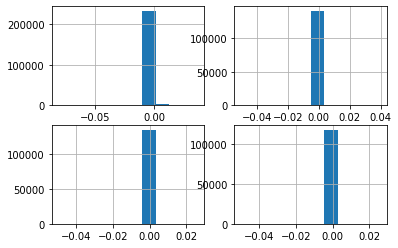

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=2)

aapl_1min.norm_returns.hist(ax=axes[0,0])
aapl_dollar.norm_returns.hist(ax=axes[0,1])
aapl_tick.norm_returns.hist(ax=axes[1,0])
aapl_volume.norm_returns.hist(ax=axes[1,1])


((array([-4.38277084, -4.18558435, -4.0783895 , ...,  4.0783895 ,
          4.18558435,  4.38277084]),
  array([-0.04991133, -0.03247121, -0.02236195, ...,  0.0164067 ,
          0.01660218,  0.02581155])),
 (0.00047132882575779805, 2.013445302176362e-06, 0.8325972015248408))

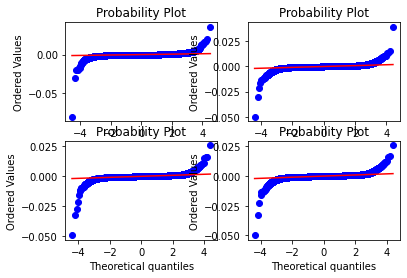

In [242]:
fig2, axes2 = plt.subplots(nrows=2, ncols=2)
stats.probplot(aapl_1min.norm_returns, dist='norm', plot=axes2[0,0])
stats.probplot(aapl_dollar.norm_returns, dist='norm', plot=axes2[0,1])
stats.probplot(aapl_tick.norm_returns, dist='norm', plot=axes2[1,0])
stats.probplot(aapl_volume.norm_returns, dist='norm', plot=axes2[1,1])



## Question 5

**Download the raw tick data for AAPL from AAPL_raw_tick_data.bz2. Construct the “order flow” from this data.  You will need to read Chan, 2017, Machine Trading, Chapter 6 to understand order flow and answer this question. (35 points) .**


The code below attempts to replicate the BVC from the text. 

First we'll take the raw data then convert it to volume bars. We use 22000 as the volume threshold based on the minimum volume from the volume dataset. 

Then we'll create our object with the info and then run some additional calculations.

For this exercise, we'll just do a flag of buy if the net order flow calculation in the 'calced' column is > 0 and a flag of sell if <= 0. 


In [243]:
# guess the volume threshold
aapl_volume.dataframe['volume'].min()

22000

In [244]:
created_volume = make_volume_bar(raw_data, 22000)
created_volume.drop('volume', axis=1, inplace=True)
created_volume.head()

,date_time,open,high,low,close,total_volume
0,2019-01-02 05:02:28,154.400,154.700,153.010,154.620,22012
1,2019-01-02 07:00:00,154.670,154.700,154.100,154.500,22063
2,2019-01-02 07:18:04,154.500,155.180,154.500,155.180,22551
3,2019-01-02 07:33:50,154.950,155.350,154.800,154.830,22073
4,2019-01-02 07:58:04,154.830,155.000,154.500,154.600,22044


In [245]:
aapl_volume.dataframe.tail()

,open,high,low,close,volume
date_time,,,,,
2019-06-14 16:00:05,192.740,192.740,192.740,192.740,30363
2019-06-14 16:00:09,192.740,192.740,192.740,192.740,48053
2019-06-14 16:02:48,192.740,192.940,192.680,192.680,22597
2019-06-14 16:19:48,192.680,192.740,192.550,192.740,30746
2019-06-14 17:19:27,192.740,192.740,192.530,192.600,23900


In [246]:
created_volume.tail()

,date_time,open,high,low,close,total_volume
116856,2019-06-14 16:00:09,192.740,192.740,192.740,192.740,44979
116857,2019-06-14 16:03:25,192.740,192.940,192.680,192.690,24708
116858,2019-06-14 16:19:48,192.690,192.740,192.550,192.740,24096
116859,2019-06-14 17:19:27,192.650,192.740,192.530,192.600,22100
116860,2019-06-14 17:32:34,192.580,192.580,192.580,192.580,1210


In [247]:
q5 = BarType('q5_created_volume', 'close')
q5.useDataframe(created_volume)

In [248]:
q5.std = q5.log_returns.std()

In [249]:
q5.dataframe['logdiff'] = np.log(q5.dataframe['close'] / q5.dataframe['close'].shift(1)).dropna()

In [250]:
q5.dataframe['zscore'] = (q5.dataframe['logdiff'] - q5.dataframe['logdiff'].mean()) / (q5.std)

In [251]:
q5.dataframe['calced'] = 22000*(2*stats.norm.cdf((q5.dataframe['logdiff']/q5.dataframe['zscore']))-1)

In [252]:
q5.dataframe['calced'].describe()

count   116860.000
mean         9.777
std          5.292
min      -1179.185
25%         10.229
50%         10.296
75%         10.389
max        800.328
Name: calced, dtype: float64

In [253]:
q5.dataframe['sign'] = np.where(q5.dataframe['calced'] > 0, 'buy', 'sell')

In [257]:
q5.dataframe.head()

,date_time,open,high,low,close,total_volume,logdiff,zscore,calced,sign
0,2019-01-02 05:02:28,154.400,154.700,153.010,154.620,22012,NaN,NaN,NaN,sell
1,2019-01-02 07:00:00,154.670,154.700,154.100,154.500,22063,-0.001,-1.324,10.292,buy
2,2019-01-02 07:18:04,154.500,155.180,154.500,155.180,22551,0.004,7.469,10.321,buy
3,2019-01-02 07:33:50,154.950,155.350,154.800,154.830,22073,-0.002,-3.845,10.308,buy
4,2019-01-02 07:58:04,154.830,155.000,154.500,154.600,22044,-0.001,-2.533,10.304,buy
